# Figure 004 (v001)

Cell lines covariates of sex chromosomes and TP53 mutants.

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import arviz as az
import janitor  # noqa: F401
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
import speclet.plot as sp
from speclet.io import figure_img_file, tables_dir
from speclet.plot.color_pal import (
    lineage_color_pal,
    pal_to_legend_handles,
    sublineage_color_pal,
)
from speclet.project_configuration import arviz_config

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sp.set_speclet_theme(sp.PlottingMode.DISSERTATION)
arviz_config()

In [5]:
FIGNUM, VERSION = 4, 1
FIGURE_FILE = figure_img_file(FIGNUM, VERSION, "cell-tp53-sex-chrom")
FIGURE_FILE

PosixPath('/n/data1/hms/dbmi/park/Cook/speclet/figures/figure_004-v001/fig_004-v001_cell-tp53-sex-chrom.png')

In [6]:
notebook_output_dir = tables_dir() / "100_106_molecular-cellular-covariates"

### Data

In [7]:
sublineage_pal = sublineage_color_pal()
lineage_pal = lineage_color_pal()

In [8]:
x_chrom_diff = pd.read_csv(notebook_output_dir / "X-chrom-difference-draws.csv").drop(
    columns=["Unnamed: 0"]
)
sex_data = pd.read_csv(notebook_output_dir / "cell-line-sexes.csv")
tp53_diff = pd.read_csv(notebook_output_dir / "tp53-difference-draws.csv")
tp53_data = pd.read_csv(notebook_output_dir / "tp53-mutation-data.csv")

## Figure

In [9]:
def _hdi_not_includes_zero(df: pd.DataFrame, var_names: list[str]) -> pd.DataFrame:
    res: dict[str, bool] = {}
    for v in var_names:
        hdi = az.hdi(df[v].values)
        res[v] = not (hdi[0] < 0 < hdi[1])
    return pd.DataFrame(res, index=[0])


def test_hdi_not_includes_zero(df: pd.DataFrame, var_names: list[str]) -> pd.DataFrame:
    return (
        df.groupby("lineage_subtype")
        .apply(_hdi_not_includes_zero, var_names=var_names)
        .reset_index(drop=False)
        .drop(columns=["level_1"])
    )


xchrom_hdi = test_hdi_not_includes_zero(x_chrom_diff, ["k", "m"])
tp53_hdi = test_hdi_not_includes_zero(tp53_diff, ["mu_k", "mu_m"])
tp53_hdi.head(3)

,lineage_subtype,mu_k,mu_m
0,bile duct (cholangiocarcinoma),True,True
1,bile duct (gallbladder adenocarcinoma),False,False
2,blood (ALL),True,True


In [10]:
_hdi_not_includes_zero(x_chrom_diff, ["k", "m"])

,k,m
0,False,False


In [11]:
_hdi_not_includes_zero(tp53_diff, ["mu_k", "mu_m"])

,mu_k,mu_m
0,False,False


In [12]:
def _plot_comparison_distributions(
    df: pd.DataFrame,
    axes: plt.Axes,
    hdi_res: pd.DataFrame,
    pal: dict[str, str] | None = None,
) -> None:
    df = df.copy().astype({"variable": "category"})
    hdi_res = (
        hdi_res.copy()
        .pivot_longer(["lineage_subtype"])
        .astype({"variable": "category"})
    )

    ax = axes[0]
    ax.axvline(0, c="k", lw=0.5, zorder=1)
    sns.boxplot(
        data=df,
        y="variable",
        x="value",
        hue="variable",
        palette=pal,
        linewidth=0.5,
        width=0.8,
        dodge=False,
        ax=ax,
        showfliers=False,
        zorder=20,
        boxprops={"zorder": 20},
        saturation=1,
    )
    ax.set_xlabel(None)
    ax.get_legend().remove()

    ax = axes[1]
    ax.axvline(0, c="k", lw=0.5, zorder=1)

    for res in [False, True]:
        _hdi_filter = hdi_res.copy().query(f"value == {res}").drop(columns=["value"])
        _df = (
            df.copy()
            .merge(_hdi_filter, on=["lineage_subtype", "variable"], how="right")
            .reset_index(drop=True)
        )
        sns.boxplot(
            data=_df,
            y="lineage_subtype",
            x="value",
            hue="variable",
            palette=pal,
            linewidth=0.5,
            width=0.8,
            ax=ax,
            showfliers=False,
            zorder=20,
            boxprops={"zorder": 20, "alpha": 1.0 if res else 0.5},
            saturation=1,
        )
    ax.get_legend().remove()
    ax.grid(True, axis="y")

In [13]:
c1, c2 = "#ED3958", "#318698"
xchrom_pal = {"k": c1, "m": c2}
xchrom_pal_show = {f"${k}" + r"_\mathrm{X}$": v for k, v in xchrom_pal.items()}
tp53_pal = {f"mu_{k}": v for k, v in xchrom_pal.items()}
tp53_pal_show = {rf"$\mu_{k}$": v for k, v in xchrom_pal.items()}

Text(0.68, 0.985, 'b')

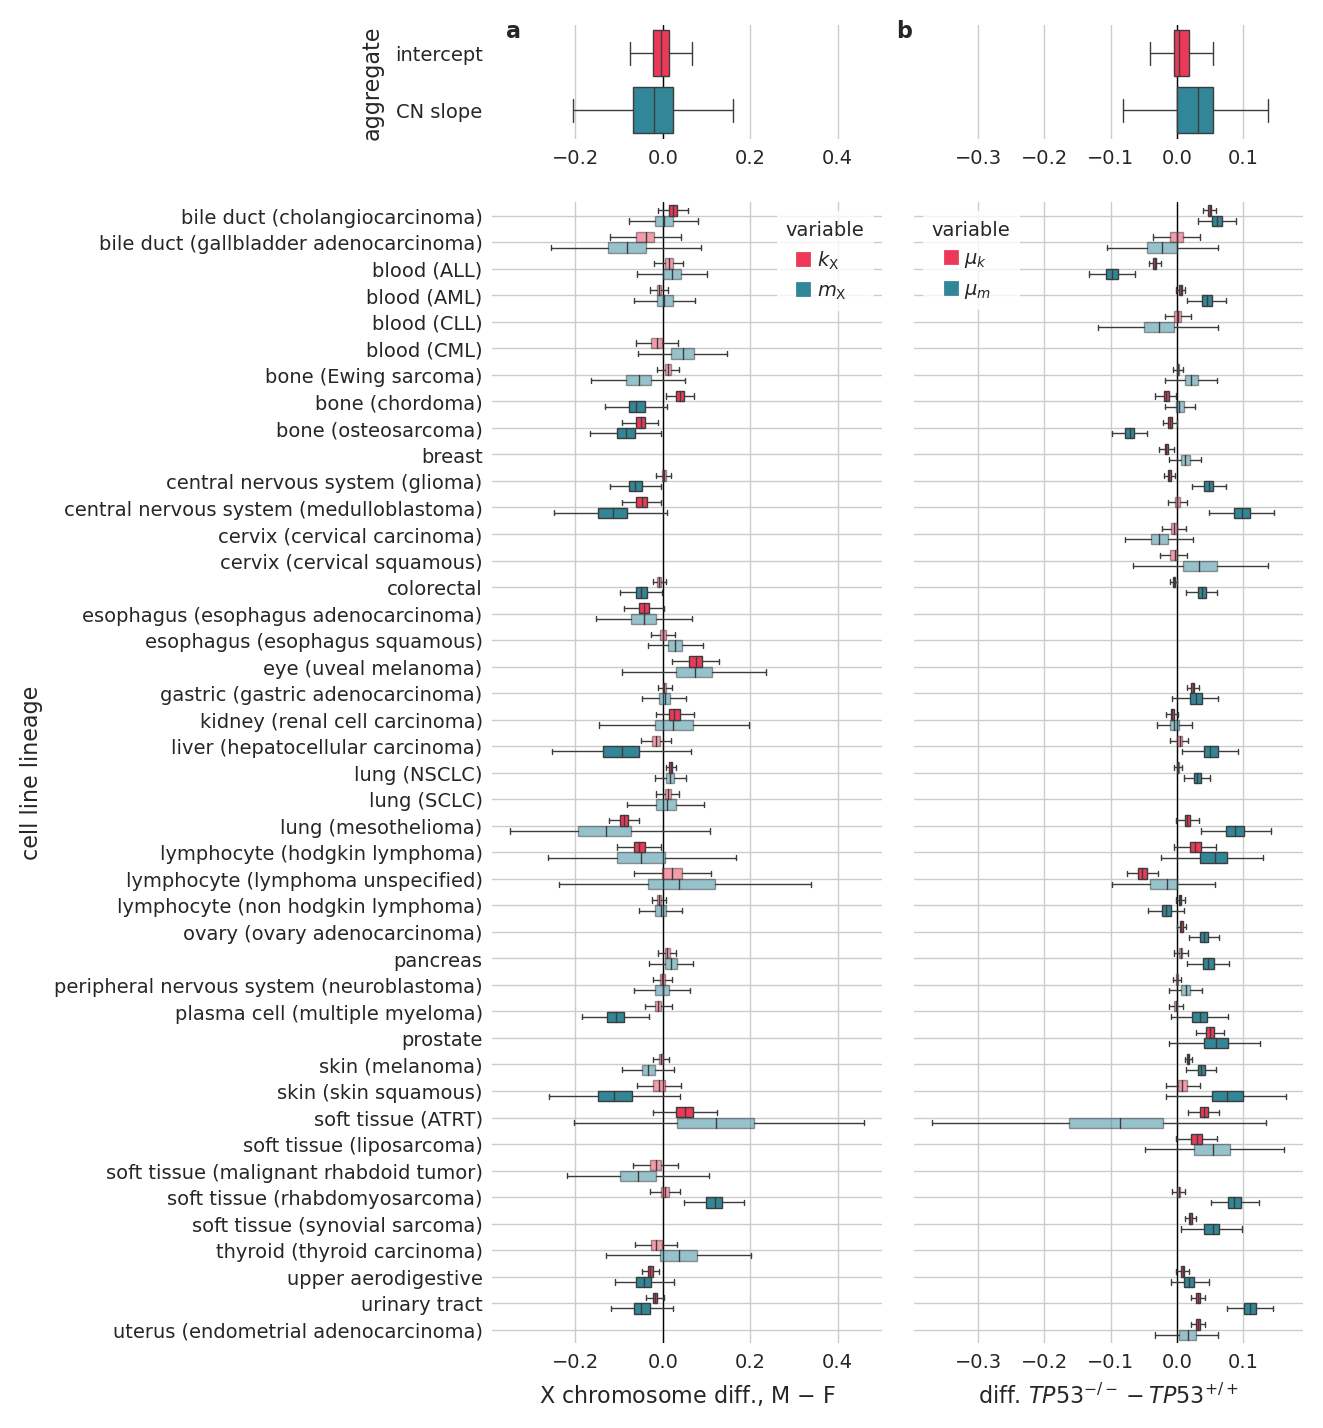

In [14]:
FIGSIZE = (6.5, 7)
figure = plt.figure(constrained_layout=True, figsize=FIGSIZE)
gs = figure.add_gridspec(
    2, 2, width_ratios=(1, 1), height_ratios=(1, 10), hspace=0.05, wspace=0.05
)
Xchrom_top_ax = figure.add_subplot(gs[0, 0])
Xchrom_bot_ax = figure.add_subplot(gs[1, 0], sharex=Xchrom_top_ax)
tp53_top_ax = figure.add_subplot(gs[0, 1], sharey=Xchrom_top_ax)
tp53_bot_ax = figure.add_subplot(gs[1, 1], sharex=tp53_top_ax, sharey=Xchrom_bot_ax)

all_subtypes = list(
    x_chrom_diff["lineage_subtype"].toset().union(tp53_diff["lineage_subtype"].toset())
)
all_subtypes.sort()
xchrom_hdi["lineage_subtype"] = pd.Categorical(
    xchrom_hdi["lineage_subtype"], categories=all_subtypes
)
tp53_hdi["lineage_subtype"] = pd.Categorical(
    tp53_hdi["lineage_subtype"], categories=all_subtypes
)

plot_df = (
    x_chrom_diff.groupby("lineage_subtype")
    .apply(lambda df: df.sample(n=1000, random_state=12))
    .reset_index(drop=True)
    .pivot_longer(["lineage_subtype"], ["k", "m"])
    .assign(
        lineage_subtype=lambda d: pd.Categorical(
            d["lineage_subtype"], categories=all_subtypes
        )
    )
)
_plot_comparison_distributions(
    plot_df, [Xchrom_top_ax, Xchrom_bot_ax], hdi_res=xchrom_hdi, pal=xchrom_pal
)


plot_df = (
    tp53_diff.groupby("lineage_subtype")
    .apply(lambda df: df.sample(n=1000, random_state=12))
    .reset_index(drop=True)
    .pivot_longer(["lineage_subtype"], ["mu_k", "mu_m"])
    .assign(
        lineage_subtype=lambda d: pd.Categorical(
            d["lineage_subtype"], categories=all_subtypes
        )
    )
)
_plot_comparison_distributions(
    plot_df, [tp53_top_ax, tp53_bot_ax], hdi_res=tp53_hdi, pal=tp53_pal
)

Xchrom_top_ax.set_ylabel("aggregate")
Xchrom_top_ax.set_yticklabels(["intercept", "CN slope"])
Xchrom_bot_ax.set_ylabel("cell line lineage")
Xchrom_bot_ax.set_xlabel("X chromosome diff., M $-$ F")
tp53_bot_ax.set_xlabel("diff. $TP53^{-/-} - TP53^{+/+}$")
tp53_bot_ax.tick_params("y", labelleft=False)
tp53_top_ax.tick_params("y", labelleft=False)
tp53_bot_ax.set_ylabel(None)
tp53_top_ax.set_ylabel(None)

leg_kwargs = {
    "title": "variable",
    "handletextpad": 0.7,
    "handlelength": 0,
    "frameon": True,
    "edgecolor": "white",
}
handles_kwargs = {"lw": 0, "marker": "s", "markersize": 4}
Xchrom_bot_ax.legend(
    handles=pal_to_legend_handles(xchrom_pal_show, **handles_kwargs),
    loc="upper right",
    **leg_kwargs,
)
tp53_bot_ax.legend(
    handles=pal_to_legend_handles(tp53_pal_show, **handles_kwargs),
    loc="upper left",
    **leg_kwargs,
)

figure.text(0.38, 0.985, "a", fontsize=8, fontweight="bold")
figure.text(0.68, 0.985, "b", fontsize=8, fontweight="bold")

## Saving

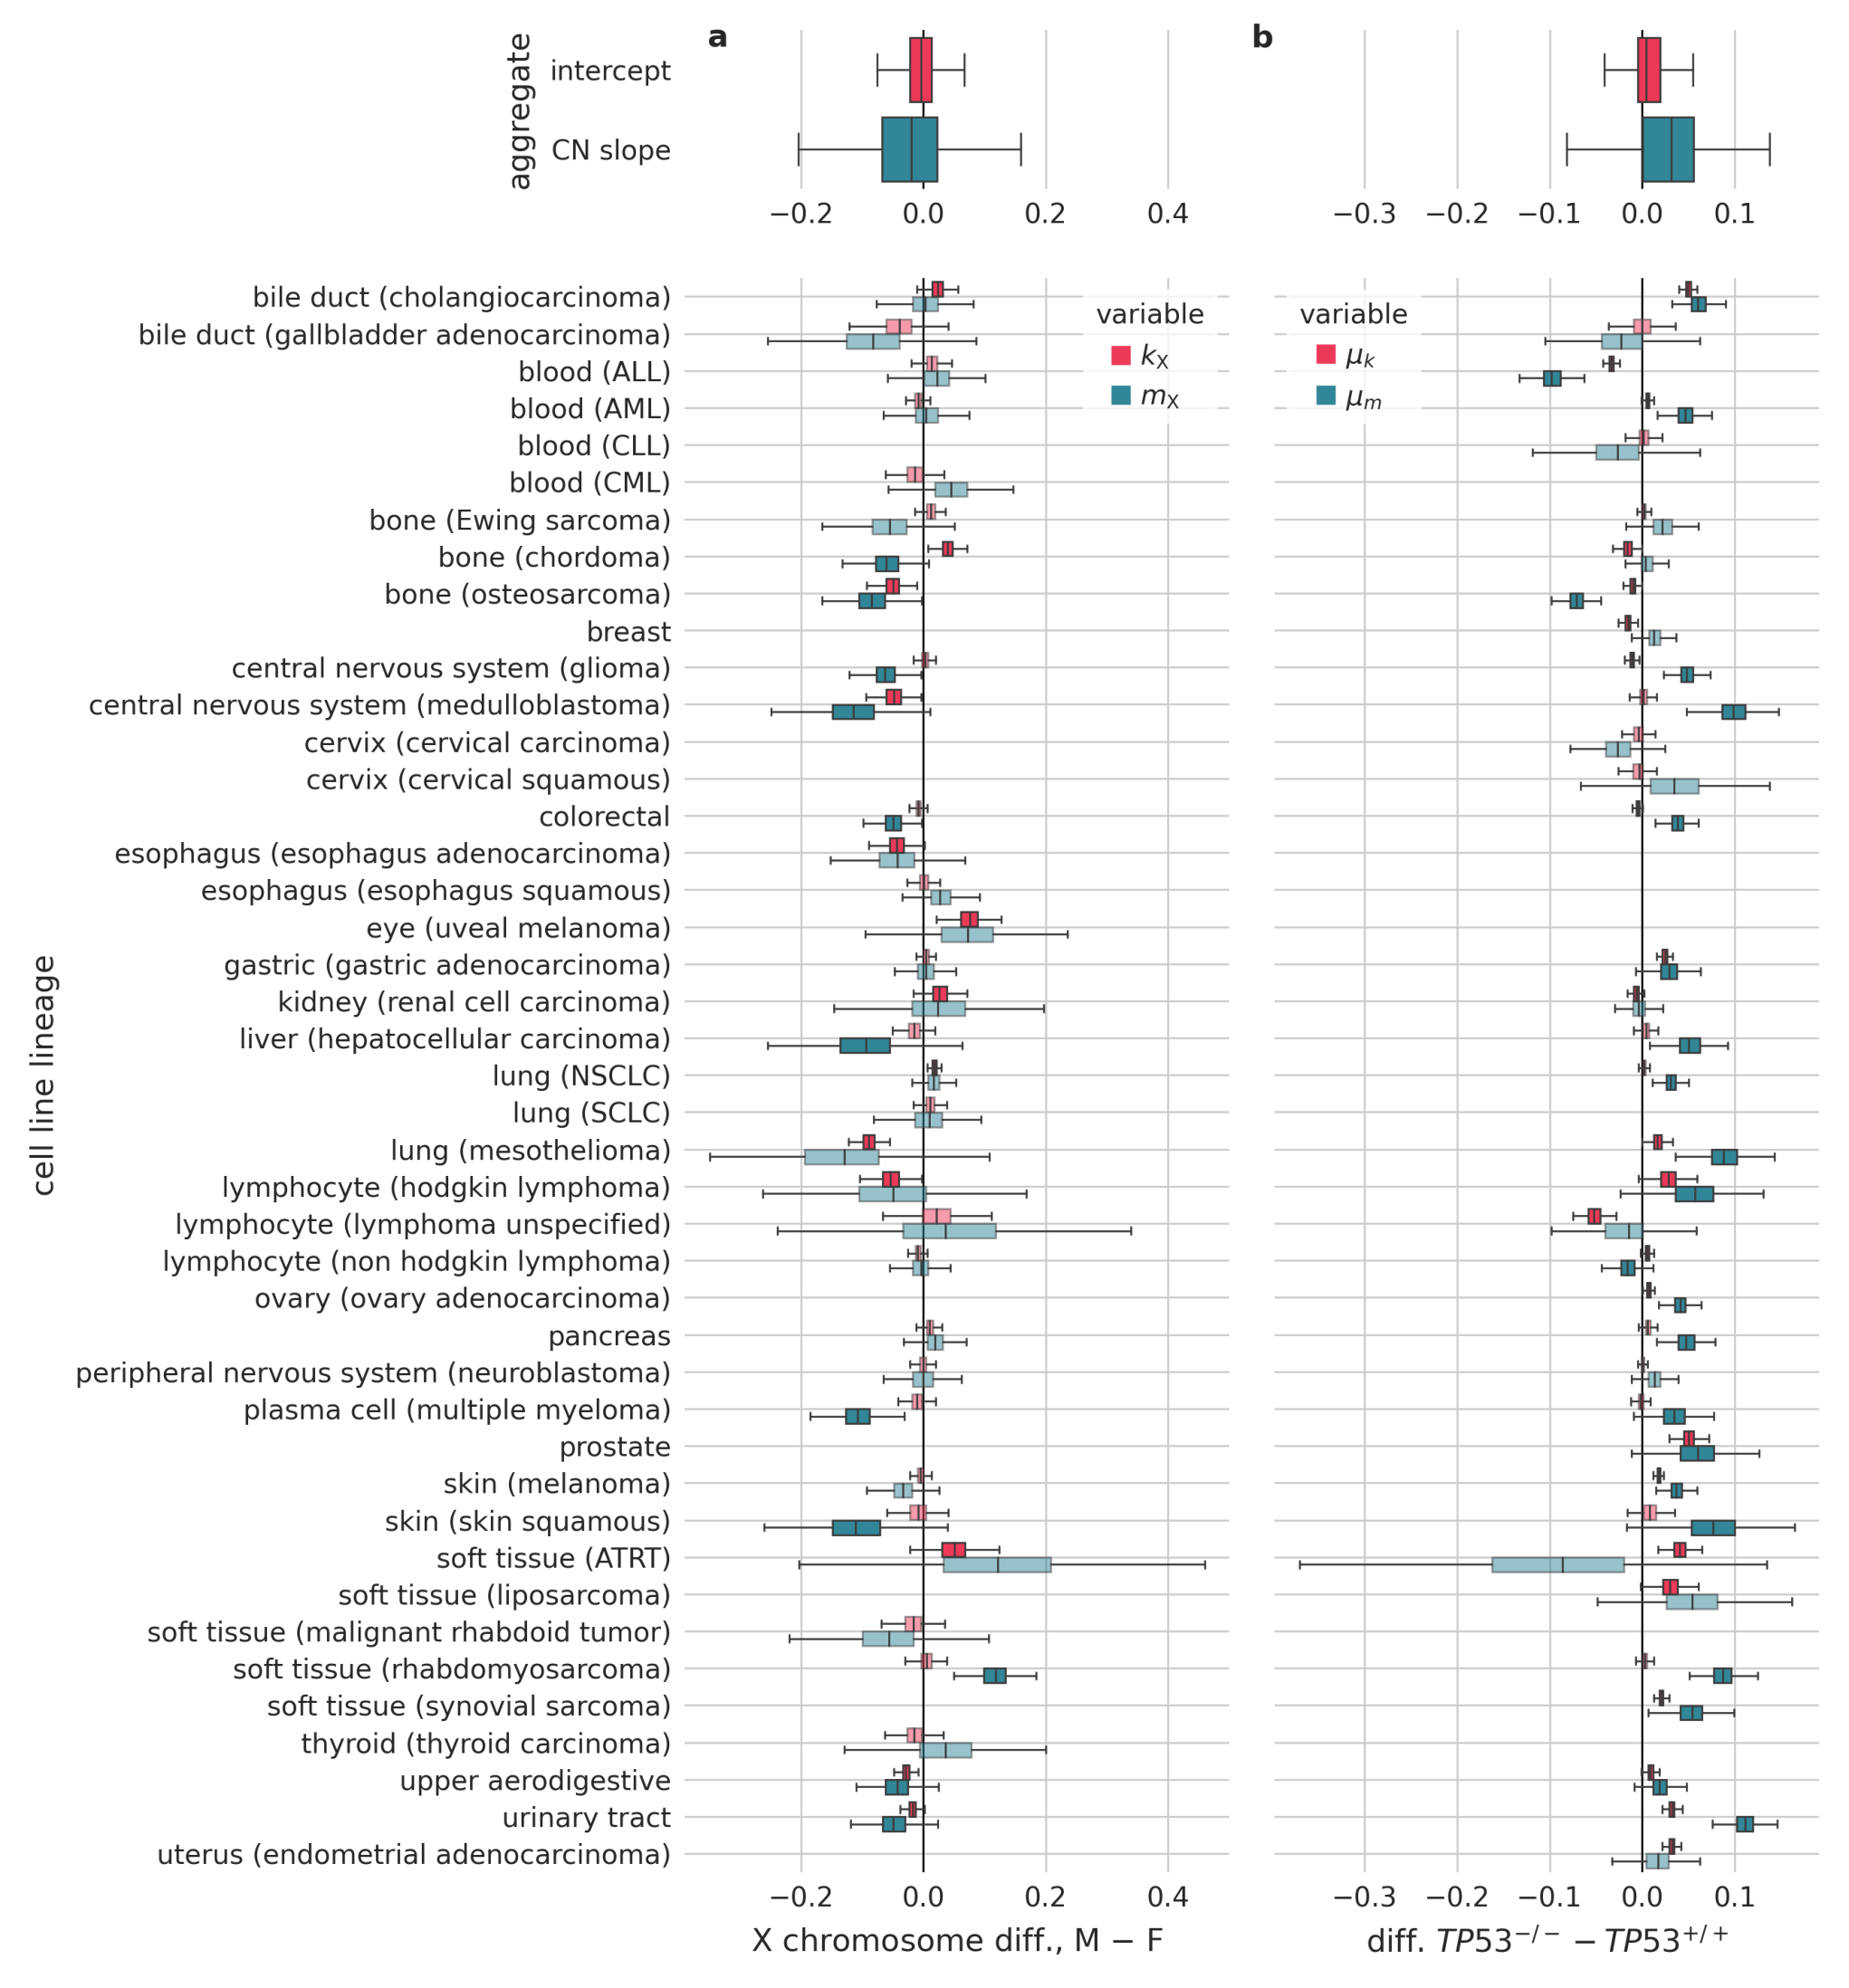

In [15]:
figure.savefig(FIGURE_FILE, dpi=400, pad_inches=0)

_, ax = plt.subplots(figsize=[x * 2 for x in FIGSIZE])
ax.imshow(plt.imread(FIGURE_FILE))
ax.axis("off")
plt.show()

---

## Session Info

In [16]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-09-26

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 3.10.0-1160.76.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-16-171.o2.rc.hms.harvard.edu

Git branch: figures

seaborn   : 0.11.2
janitor   : 0.22.0
arviz     : 0.12.1
speclet   : 0.0.9000
matplotlib: 3.5.3
pandas    : 1.4.4

